In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from energy_harvest import EnergyHarvester
from apply_policy import sparsify_data, classify_packets

from utils.setup_funcs import *
from datasets.dsads_contig.dsads import *
from models import *
from datasets.apply_policy import *

In [42]:
root_dir = os.path.join(PROJECT_ROOT,"../data/dsads/merged_preprocess")
train_data = np.load(f"{root_dir}/training_data.npy")
train_labels = np.load(f"{root_dir}/training_labels.npy")

val_data = np.load(f"{root_dir}/val_data.npy")
val_labels = np.load(f"{root_dir}/val_labels.npy")

test_data = np.load(f"{root_dir}/testing_data.npy")
test_labels = np.load(f"{root_dir}/testing_labels.npy")

# preprocess
mean = torch.tensor(np.mean(train_data,axis=0))
std = torch.tensor(np.std(train_data,axis=0))
# cannot apply here because need units of m/s^2 for harvesting
# train_data = (train_data-mean)/(std + 1e-5)
# val_data = (val_data-mean)/(std + 1e-5)
# test_data = (test_data-mean)/(std + 1e-5)

# load pretrained classifier
model = SimpleNet(3,10)
ckpt_path = os.path.join(PROJECT_ROOT,f"saved_data/checkpoints/dsads_contig/seed{123}.pth")
model.load_state_dict(torch.load(ckpt_path)['model_state_dict'])


<All keys matched successfully>

In [ ]:
FS = 25 # sampling frequency
PACKET_SIZE = 8
LEAKAGE = 6e-6
INIT_OVERHEAD = 150e-6

val_data = val_data[6000:8000,:]
val_labels = val_labels[6000:8000]

In [46]:
eh = EnergyHarvester()
	
# add time axis
t_axis = np.arange(len(val_labels))/FS
t_axis = np.expand_dims(t_axis,axis=0).T

# add the time axis to the data
full_data_window = np.concatenate([t_axis,val_data],axis=1)

opp_packets, opp_e_trace = sparsify_data(full_data_window,PACKET_SIZE,LEAKAGE,INIT_OVERHEAD,eh,'opportunistic',train_mode=False)
	

IndexError: index 1 is out of bounds for axis 0 with size 0

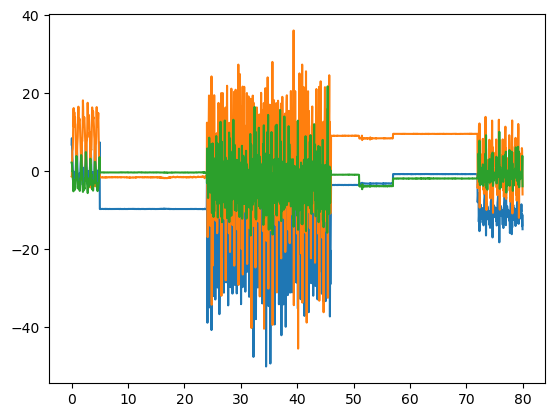

In [32]:
plt.plot(full_data_window[:,0],full_data_window[:,1])
plt.plot(full_data_window[:,0],full_data_window[:,2])
plt.plot(full_data_window[:,0],full_data_window[:,3])

In [25]:
opp_packets

(array([28.16, 29.12, 30.2 , 31.36, 32.52, 33.6 , 34.72, 35.72, 37.  ,
        38.16, 39.28, 40.36, 41.32, 42.48, 43.56, 44.76, 45.84, 79.36]),
 array([[[-2.8979e+00, -1.5894e+01, -5.2569e+00],
         [ 5.3049e+00, -2.2595e+00,  9.8987e+00],
         [ 1.4413e+00,  1.2385e+01, -1.3033e+01],
         [-5.1426e+00,  8.1553e+00, -1.2616e+00],
         [-1.5728e+01,  1.0158e+01, -6.5118e-01],
         [-1.0139e+01, -2.0704e+01,  8.4080e+00],
         [-2.0588e+01, -1.6227e+01, -6.9474e+00],
         [-2.9703e+01,  2.4966e+00,  5.0861e+00]],
 
        [[-1.1164e+00, -2.4193e+01, -6.1799e+00],
         [-1.8719e+01, -1.1531e+01, -5.3244e+00],
         [-2.9121e+01,  9.0469e+00,  6.7263e+00],
         [-2.2289e+01, -2.0162e+00, -9.9682e+00],
         [-1.7138e+01,  1.1046e+01, -8.7553e-01],
         [-6.5110e+00,  1.1967e+01, -3.0339e+00],
         [ 2.7071e+00,  2.0854e+01, -8.5905e+00],
         [ 2.2775e+00,  9.4408e+00, -3.3365e-01]],
 
        [[-1.4619e+00,  2.2810e+00,  9.1200e-01],


In [ ]:
dense_outputs, dense_preds, dense_targets, dense_outputs_opp, dense_preds_opp, dense_targets_policy = classify_packets(val_data,val_labels,opp_packets,model,PACKET_SIZE, mean, std)